# Feature egineering

Мы узнали про достаточное количество алгоритмов машинного обучения для решения  задач классификации и решрессии, и про то, как оценивать качество алгоритмов

Следующий шаг - научиться настраивать алгоритмы для получения максимального качества

В задачи unsupervised и supervised объединяет общий элемент - матрица *объекты* $\times$ *признаки* размерность $m \times n$, где $m$ - число объектов, а $n$ - число признаков

$$
X = \left[
\begin{array}{cccc}
x_{11} & x_{12} & \ldots & x_{14} \\
x_{21} & x_{22} & \ldots & x_{14} \\
\ldots & \ldots & \ldots & \ldots \\
x_{m1} & x_{m2} & \ldots & x_{mn} \\
\end{array}
\right]
$$

Таким образом, каждый объект описан признаками(фичами) в количестве $n$ штук: $x^i = (x_1, x_2, \ldots, , x_n)$. Мы уже знаем, что фичи бывают численными и категориальными.


In [2]:
import os
import shutil

import numpy as np

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)))

Содержимое директории /Users/adzhumurat/PycharmProjects/ai_product_engineer/data: ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data', 'content_catalog.zip', 'user_item_views.zip', 'pipelines-data', 'zinc_data', 'content_views.csv.gz', 'nltk-data', 'Health_and_Personal_Care.jsonl.gz', 'mlflow', 'test_dataset.pkl', 'models', 'ground_truth_dataset.pkl', 'minio', 'final_dataset.zip', 'content_views.csv', 'logs', 'ocr_dataset.zip', 'content_description.csv.gz', 'scored_corpus.csv', 'meta_Health_and_Personal_Care.jsonl.gz', 'brand_tweets.csv', 'brand_tweets_valid.csv']


Фичи можно назвать "топливом" алгоритмов машинного обучения. Хорошие фичи позволят повысить качество решения задачи, примерно как на картинке

![ml_blackbox](img/ml_blackbox.png)


В алгоритмах машинного обучения и анализа данных часто встречаются требования к фичам входных данных
* распределение данных
* масштаб

Перед аналитиком часто стоит задача трансформации (преобразования) входных данных таким образом, чтобы удовлетворить условиям алгоритма. Игнорирование требований к входным данным приводит некорректным выводам, это основной принцип ML (и не только ML): **garbage in - garbage out**. Процесс "придумывания" фичей называется feature engineering

В этом занятии поговорим о том, как трансформировать исходный csv файл в набор фичей

# Визуализации данных

Это первый этап исследования - оценить визуально, с чем предстоит работать

Чаще всего используется визуализация `scatter plot`

In [3]:
import pandas as pd

input_dataset_df = pd.read_csv(os.path.join(root_data_dir, 'final_dataset.zip'), compression='zip')
logger.info('num rows %d', input_dataset_df.shape[0])

input_dataset_df.head()

2025-10-22 07:38:22,231 : num rows 100000


,content_id,num_views,num_positve_actions,num_smiles,num_saves,num_shares,num_repubs,num_comments,num_days_on_service,featured_approval_content_declined,declined_reason,best_class,approved,hard_shotted,soft_shotted
0,IzpfrtD,127770,12725,12455,168,141,556,1784,25,0.0,NaN,NaN,NaN,NaN,NaN
1,FibDyiC,86090,6180,5704,173,383,289,6016,5,1.0,racism,approved,0.908444,0.033255,0.058302
2,LUkUBEm,78286,5228,4944,376,29,162,165,6,0.0,NaN,approved,0.994736,0.002517,0.002748
3,zPrfyiz,76931,5664,5506,231,8,151,395,5,1.0,politics_religion,approved,0.987415,0.008829,0.003755
4,eNAyJnh,72021,6148,5844,453,16,261,113,5,1.0,racism,approved,0.989974,0.005185,0.004841


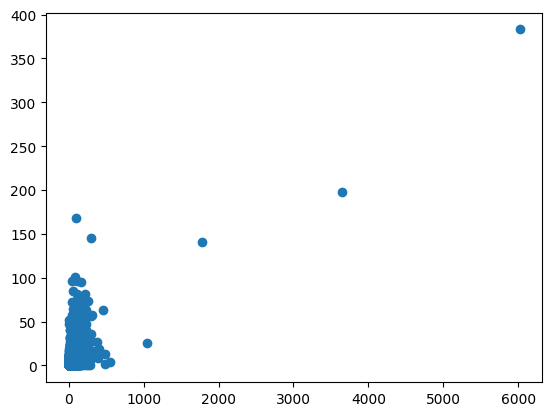

In [4]:
from matplotlib import pyplot as plt

plt.scatter(input_dataset_df['num_comments'], input_dataset_df['num_shares'])

Выглядит странно, как будто есть небольшое количество данных, больших по модулю и большое количество данных около-нулевых - такие большие элементы называют выбросами (outliers)

Строим гистограмму

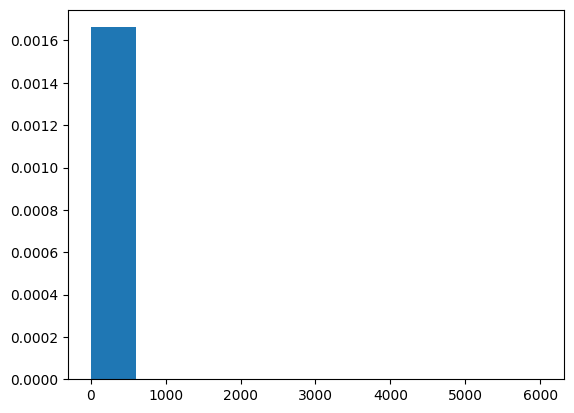

In [5]:
plt.hist(input_dataset_df['num_comments'], bins=10, density=True)
plt.show()

Выглядит странно, как будто есть небольшое количество данных, больших по модулю и большое количество данных около-нулевых - такие большие элементы называют выбросами (outliers)

Выявляем выбросы

In [6]:
input_dataset_df['num_comments'].describe(percentiles=[.5, .95, .99])

count    100000.000000
mean          3.785670
std          26.087273
min           0.000000
50%           1.000000
95%          12.000000
99%          52.000000
max        6016.000000
Name: num_comments, dtype: float64

Как ещё проверить на выбросы? С помощью `.boxplot()`


<Axes: >

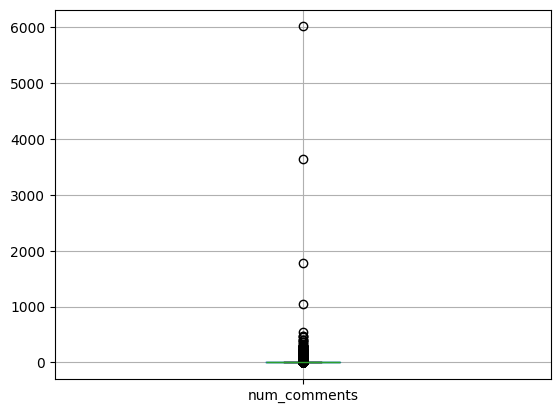

In [7]:

input_dataset_df[['num_comments']].boxplot()



Переделываем гистограмму (без выбросов)


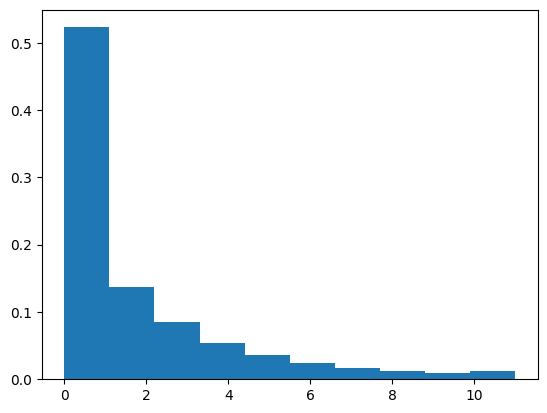

In [8]:

plt.hist(
    input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments'],
    bins=10, density=True
)
plt.show()

Получили т.н. распределение с "тяжёлым хвостом" - разберёмся как трансформировать эти данные в следующем разделе

### Пропущенные значения

В препроцессинге есть ещё один важный этап - работа с пропусками

In [18]:
null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
print('Доля пропущенных значений %.4f' % null_values_share)

Доля пропущенных значений 0.7111


Заменяем `NULL` на пустую строку

In [19]:
input_dataset_df['declined_reason'].fillna(value='Value missed', inplace=True)

null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
print('Доля пропущенных значений %.4f', null_values_share)
input_dataset_df['declined_reason'].value_counts()

Доля пропущенных значений %.4f 0.0


/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_60370/2059529957.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  input_dataset_df['declined_reason'].fillna(value='Value missed', inplace=True)


declined_reason
Value missed                   71113
politics_religion              10102
racism                          3753
lgbt_woman_jokes                2898
not_safe_for_work               2619
Political_Lite                  1957
tragedy_death_gore_injuries     1810
watermark                       1305
call_to_harm                    1211
nudity_censored_genitals        1002
moderation_mistake               696
pedo                             460
clickbait                        442
disabilities                     213
bodily_fluids                    178
drugs                            106
school_shooting_fights            81
pepe                              38
pity                              15
jailbait                           1
Name: count, dtype: int64

### Кодирование категориальных фичей

Уже встречали этот метод в занятии по линейной регрессии - кодируем категориальные фичи

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le_transformed = le.fit_transform(input_dataset_df['declined_reason'])

pd.Series(le_transformed).value_counts().head()

1     71113
15    10102
16     3753
8      2898
10     2619
Name: count, dtype: int64

Этот метод чаще используется для анонимизации. Другой (более подходящий для линейных моделей) вид энкодинга - `OneHotEncoding`

In [21]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

ohe_transformed = ohe.fit_transform(input_dataset_df[['declined_reason']])

ohe_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100000 stored elements and shape (100000, 20)>


мы визуализировали и пофильтровали данные - можно приступать к трансформациям!

### Трансформации непрерывных фичей

В задачах линейной регрессии такие трансформации особенно важны - чтобы линейная регрессия хорошо работала должны выполняться следующие требования:

* остатки регрессии должны иметь нормальное (гауссово) распределение
* все фичи должны быть примерно в одном масшабе

При подготовке данных для обучения линейной регрессии применяются следющие приемы: масштабирование и нормализация.


Существуют чисто инженерные приёмы первичной обработки данных, например для борьбы с большими по модулю значениями обычно используют т.н. *Монотонные преобразования*:

* логарифмирование np.log
* извлечение квадратного корня np.sqrt

Оба этих преобразования являются *монотонными*, т.е. они меняют абсолютные значения, но сохраняют порядок величин.

#### z-score

Более интересный метод - это Standart Scaling или Z-score normalization. Это преобразование позволяет "сгладить" данные, избавить их от выбросов. Для этого есть инструмента [есть реализация в sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


[]

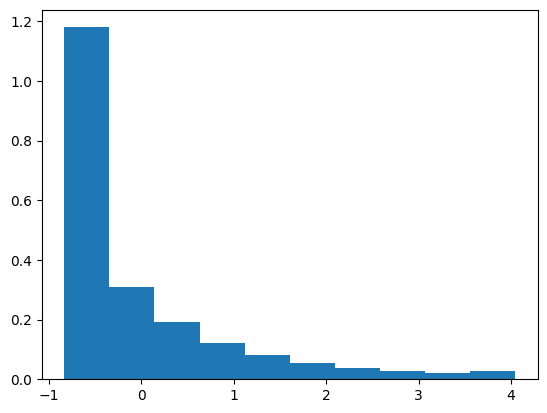

In [10]:
from sklearn.preprocessing import StandardScaler

transformed_z_score = (
    StandardScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()

/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_60370/1794593884.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(transformed_z_score), bins=5, density=True)


[]

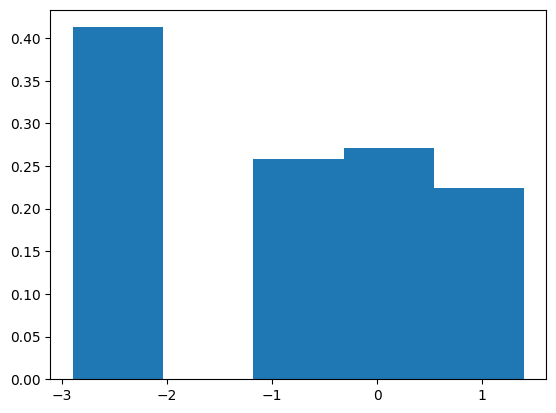

In [11]:
plt.hist(np.log(transformed_z_score), bins=5, density=True)
plt.plot()

Получили какой-то пропуск в данных, почему так вышло?

range=[%.4f, %.4f] -0.8309970700873233 4.044507671876307


/var/folders/bd/bg2rzktd7cl7_q4_11m4dx7r0000gn/T/ipykernel_60370/94988955.py:6: RuntimeWarning: invalid value encountered in log
  carrier, np.log(carrier)


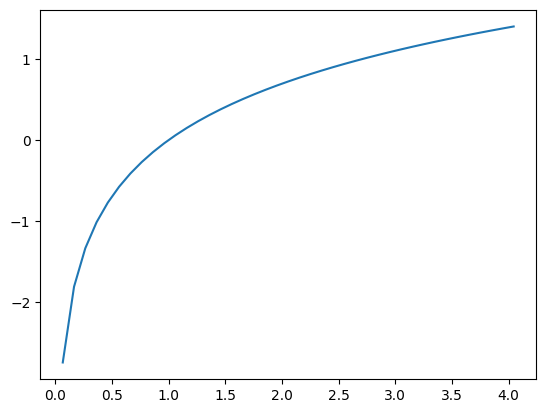

In [12]:
print('range=[%.4f, %.4f]', transformed_z_score.min(), transformed_z_score.max())

carrier = np.linspace(transformed_z_score.min(), transformed_z_score.max())

plt.plot(
    carrier, np.log(carrier)
)

По графику видно, логарифм для отрицательных чисел не определён - тут нужно применить другое масштабирование, например min-max.

Получается, что логарифмирование (и извлечение квадратного корня нельзя применять после вычисления z-score)

Нужно выбрать один из вариантов
* сначала логарифмировать, а потом применить z-score
* только z-score
* только логарифмирование

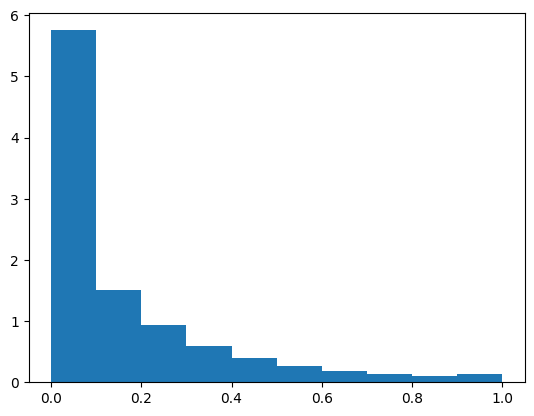

In [13]:
from sklearn.preprocessing import MinMaxScaler

transformed_z_score = (
    MinMaxScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()
plt.show()

Пример трансформации на другом датасете

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

data = pd.read_csv(os.path.join(root_data_dir, 'task.csv'))
print(data.head(3))

raw_data = data[data.columns.values[-1]].values.astype(np.float32)
print("Сырой датасет: %s" % raw_data)
print("stat = %s, p-value=%s\n" % shapiro(raw_data) )

         Код                                               Тема  \
0  HYDRA-535  Пробрасывать пользовательское распределение pa...   
1  HYDRA-534   Гибридный рекомендатель с multi-channel feedback   
2  HYDRA-532         Джоба в дженкинсе для расчёта динамики РВП   

       Компонент  Затрачено в часах  
0        echidna                  1  
1          hydra                  3  
2  hydramatrices                  2  
Сырой датасет: [ 1.  3.  2.  4.  2. 10.  2.  5.  2.  2.  1.  7.  5.  2.  5. 16. 10.  3.
 24.]
stat = 0.726285458186394, p-value=0.00011633852003649601



Проводим трансформацию фичи (масштабирование)

In [ ]:
transformed_data = StandardScaler().fit_transform(raw_data.reshape(-1, 1)).reshape(-1)
print("z-transform датасет: %s" % transformed_data)
print("stat = %s, p-value=%s\n" % shapiro(transformed_data) )

print("Проверка на нормальность p_1 > p_2: %s" % (shapiro(transformed_data)[1] > shapiro(raw_data)[1]))

Тест Шапиро-Уилка показывает, что гипотеза о нормальном распределении данных стала чуть более вероятной, чем до "Z-score" нормализации.

#### min-max normalization

Другой распространённый метод называется MinMax Scaling. Этот метод переносит все точки на отрезок [0-1]
$$
X_{scaled} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

In [ ]:
from sklearn.preprocessing import MinMaxScaler


print("Сырой датасет: %s" % raw_data)

transformed_data = MinMaxScaler().fit_transform(raw_data.reshape(-1, 1)).reshape(-1)

print("Min-Max scale датасет: %s" % transformed_data)

### Трансформации категориальных фичей

Категориальная переменная - это набор меток (классов). В приложенном датасете по задам столбец `Компонент` - категориальная фича, а `Затрачено в часах` - непрерывная

Посчитаем количество различных меток в поле "Компонент"

In [ ]:
import pandas as pd

df = pd.read_csv('data/task.csv')
print(df['Компонент'].value_counts().to_dict())
df.head()

#### Кодирование One-Hot

Кодируем вектор, где все нули и одна единица

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')

one_hot_encoded = ohe.fit_transform(df[['Компонент']])

one_hot_encoded.toarray()

#### Hashing trick

В случае, когда признаков слишком много, применяют хеширование



In [ ]:
for label in df['Компонент'].unique():
    #print(label, '->', hash(label) % 8 )
    print(label, '->', hash(label) % 12 )

Премер хеширования (с формулами!) в [Лекциях от ВШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf)

Прекрасный разбор есть на хабре в статье от [ODS про feature engineering](https://habr.com/ru/company/ods/blog/326418/#rabota-s-kategorialnymi-priznakami-label-encoding-one-hot-encoding-hashing-trick)

# Трансформации данных

Получили т.н. распределение с "тяжёлым хвостом"

Данные можно центрировать и снизить дисперсию - такое преобразование называется z-score

In [ ]:
from sklearn.preprocessing import StandardScaler

transformed_z_score = (
    StandardScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()

Можно ли применять логарифмирование всегда?

Давайте попробуем

In [ ]:
plt.hist(np.log(transformed_z_score), bins=5, density=True)
plt.plot()

Получили какой-то пропуск в данных, почему так вышло?

In [ ]:
logger.info('range=[%.4f, %.4f]', transformed_z_score.min(), transformed_z_score.max())

carrier = np.linspace(transformed_z_score.min(), transformed_z_score.max())

plt.plot(
    carrier, np.log(carrier)
)

Получается, в numpy логарифм для отрицательных чисел не определён - тут нужно применить другое масштабирование, например min-max.

Получается, что логарифмирование (и извлечение квадратного корня нельзя применять после вычисления z-score)

Нужно выбрать один из вариантов 
* сначала логарифмировать, а потом применить z-score
* только z-score
*только логарифмирование

In [ ]:
from sklearn.preprocessing import MinMaxScaler

transformed_z_score = (
    MinMaxScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()
plt.show()

# Пропущенные значения

Проверка на пропущенные значения

In [ ]:
null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
logger.info('Доля пропущенных значений %.4f', null_values_share)

Заменяем `NULL` на пустую строку

In [ ]:
input_dataset_df['declined_reason'].fillna(value='Value missed', inplace=True)

null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
logger.info('Доля пропущенных значений %.4f', null_values_share)

In [ ]:
input_dataset_df['declined_reason'].value_counts()

# Кодирование категориальных фичей

Кодируем категориальные фичи

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le_transformed = le.fit_transform(input_dataset_df['declined_reason'])

pd.Series(le_transformed).value_counts().head()

Другой (более подходящий) вид энкодинга

In [ ]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

ohe_transformed = ohe.fit_transform(input_dataset_df[['declined_reason']])

ohe_transformed

# Текстовые фичи

## Bag of words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word',
    lowercase=True,
    token_pattern=r'\b[\w\d]{3,}\b',
    min_df=0.001
)

bow_matrix = vectorizer.fit_transform(ocr_dataset_df.text.values)
bow_matrix

По sparse матрице можно найти попарное расстояние между текстами

In [ ]:
from sklearn.metrics import pairwise_distances

text_distance = 1 - pairwise_distances(bow_matrix, metric="cosine")

text_distance.shape

Мы получили квадратную матрицy, которая содержит столько строк и столбцов, сколько документов в нашем корпусе (наборе текстов).

Зачем нужна такая матрица? Например, можно искать "похожие" тексты для задачи рекомендаций

In [ ]:
source_tweet_index = 14  # тут может быть любое число в диапазоне от 1 до 1000

print(ocr_dataset_df.iloc[source_tweet_index].text)

Находим ближайший похожий текст

отсортируем твиты по “похожести” - чем похожее на `source_tweet_index`, тем ближе к началу списка sorted_similarity

In [ ]:
sorted_similarity = np.argsort(-1 * text_distance[source_tweet_index,:])

sorted_similarity

Теперь распечаем "схожие" тексты

In [ ]:
for content_index in sorted_similarity[:4]:
  print(ocr_dataset_df.iloc[content_index].text)
  print('-------------\n-------------')

## Препроцессинг текста

Устанавливаем NLTK. Для начала готовим директорию для данных

In [ ]:
nltk_data_dir = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021', 'nltk_data')
if not os.path.exists(nltk_data_dir):
  os.makedirs(nltk_data_dir)
  logger.info('Директория %s создана', nltk_data_dir)
logs_dir = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021', 'logs')
if not os.path.exists(logs_dir):
  os.makedirs(logs_dir)
logger.info('Подготовили директорию для nltk %s', nltk_data_dir)

Обязательно фиксируем версию! Иначе будут косяки

In [ ]:
!pip install nltk==3.6.2

In [ ]:
import nltk

nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.append(nltk_data_dir) # тут почему-то корневую надо указывать ¯\_(ツ)_/¯

In [ ]:
import nltk

sample_str = ocr_dataset_df.text.values[0]

print('== Исходный текст== \n%s\n\n' % sample_str)

tokenized_str = nltk.word_tokenize(sample_str)
print('== Токенизированный текст==\n%s' % tokenized_str)

Видим знаки препинания, надо их отфильтровать

In [ ]:
import string  # стандартный модуль

tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
print(tokens)

Стоп-слова

In [ ]:
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'shold',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
]

filtered_tokens = [i for i in tokens if ( i not in stop_words )]

print(filtered_tokens)

Соединяем в одну функцию

In [ ]:
def tokenize_text(raw_text: str):
    """Функция для токенизации текста
    
    :param raw_text: исходная текстовая строка
    """
    filtered_tokens = []
    
    filtered_tokens = [i.lower() for i in raw_text.split() if ( i not in string.punctuation )]
    filtered_tokens = [i for i in filtered_tokens if ( i not in stop_words )]
    filtered_tokens = [i for i in filtered_tokens if ( len(i) > 2 )]
    
    return filtered_tokens

# применяем функцию в датафрейму с помощью метода .apply()
tokenized_tweets= ocr_dataset_df.text.apply(tokenize_text)

# добавляем новую колонку в исходный датафрейм
ocr_dataset_df = ocr_dataset_df.assign(
    tokenized=tokenized_tweets
)

ocr_dataset_df.tokenized.head()

## Эмбеддинги Word2Vec

In [ ]:
from gensim.models import Word2Vec
import logging

texts = ocr_dataset_df.tokenized.values

model = Word2Vec(texts, size=10, window=7, min_count=2, workers=4, iter=10, sg=0)

Эмбеддинги обучились, посмотрим как они выглядят

In [ ]:
model.wv.get_vector('android')

Проверяем эмбеддинги - ищем эмбеддинг, самый похожий на эмбеддинг слова Biden

In [ ]:
# biden
model.wv.most_similar('biden')

Включаем GPU

Подробнее о модели [тут](https://pytorch.org/hub/pytorch_vision_resnet/)

![gpu_on_colab](img/gpu_on_colab_gui.png)

In [ ]:
from torchvision.models import resnet18

TORCH_MODELS_DIR = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021', 'torch_models')
try:
  os.mkdir(TORCH_MODELS_DIR)
except FileExistsError as e:
  logger.info(e)

os.environ['TORCH_HOME'] = TORCH_MODELS_DIR # TORCH_MODEL_ZOO is deprecated
rn18 = resnet18(pretrained=True)

# запускаем вычисления на GPU
# rn18 = rn18.to('cuda:0')
logger.info('Модель загружена')

# Эмбеддинги картинок

Для начала посмотрим, какие слои есть в сети

Кроме `.modules` можно было воспользоваться `.named_children()`

In [ ]:
for layer in rn18._modules:
  print(layer)

Нам нужен слой `avgpool`

Каждый слой это по сути массив c весами модели - нам нужно оставить все слои ДО того слоя, который нас интересует

In [ ]:
from torch import nn

class FeatureExtractor(nn.Module):
    def __init__(self, output_layer, torch_model):
        super().__init__()
        self.output_layer = output_layer
        self.pretrained = torch_model
        self.children_list = []
        for n,c in self.pretrained.named_children():
            self.children_list.append(c)
            if n == self.output_layer:
                logger.info('final layer archived: %s', output_layer)
                break

        self.net = nn.Sequential(*self.children_list)
        self.pretrained = None
        
    def forward(self,x):
        x = self.net(x)
        return x

Создаём объект-экстрактор с выборанным слоем

In [ ]:
resnet_extractor = FeatureExtractor(output_layer='avgpool', torch_model=rn18)


Проверяем директорию с картинками

In [ ]:
ROOT_MEMES_DIR = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021', 'memes')

os.listdir(ROOT_MEMES_DIR)[:10]

In [ ]:
from PIL import Image
from torchvision import transforms

filename = os.path.join(ROOT_MEMES_DIR, '7f3ywc.jpeg')

input_image = Image.open(filename)

In [ ]:
type(input_image)

In [ ]:
from torch import no_grad, cuda
import torchvision.transforms as transforms

# transform = transforms.ToTensor()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_tensor = preprocess(input_image)
input_batch = image_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if cuda.is_available():
    input_batch = input_batch.to('cuda')
    resnet_extractor.to('cuda')

with no_grad():
    output = resnet_extractor(input_batch)
    numpy_vector = output.reshape(-1).cpu().numpy()  # flatten(output)
    print(type(output), output.size())

In [ ]:
numpy_vector.shape

In [ ]:
import pickle

import torchvision.transforms as transforms
from PIL.JpegImagePlugin import JpegImageFile
from torch import no_grad, cuda
from PIL import Image, UnidentifiedImageError

def img2embedding(input_meme_filename: str) -> np.array:
  OUTPUT_SHAPE = 512
  numpy_vector = np.zeros(OUTPUT_SHAPE)
  preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  try:
    input_img = Image.open(input_meme_filename) # type: JpegImageFile
  except UnidentifiedImageError:
    return numpy_vector
  try:
    image_tensor = preprocess(input_img)
  except RuntimeError:
    #  logger.info('error with %s meme', meme_filename.split('/')[-1])
    return numpy_vector
  input_batch = image_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if cuda.is_available():
      input_batch = input_batch.to('cuda')
      resnet_extractor.to('cuda')

  with no_grad():
      output = resnet_extractor(input_batch)
      numpy_vector = output.reshape(-1).cpu().numpy()  # flatten(output)
  return numpy_vector


if os.path.exists(os.path.join(ROOT_MEMES_DIR, 'embed.npy')):
  embeds_matrix = np.load(os.path.join(ROOT_MEMES_DIR, 'embed.npy'))
  with open(os.path.join(ROOT_MEMES_DIR, 'file_index.pkl'), 'rb') as f:
    file_index = pickle.load(f)
    logger.info('files loaded from dump')
else:
  res = []  # тут основная информация о контенте
  file_index = {}
  TOP = 3092
  error_files = []
  logger.info('Processing started')
  dense_index = 0
  for f_name in os.listdir(ROOT_MEMES_DIR)[:TOP]:
    meme_filename = os.path.join(ROOT_MEMES_DIR, f_name)
    img_embed = img2embedding(meme_filename)
    if img_embed.sum() == 0:
      error_files.append(meme_filename)
    # сохраняяем эмбеддинг (их потом схлопнем в матрицу) и отдельно индекс файла в матрице
    res.append(img_embed)
    file_index[dense_index] = {'f_name': f_name}
    dense_index += 1
    
  if len(error_files) > 0:
    logger.info('num errors %d', len(error_files))
    for i in error_files:
      os.remove(i)

  embeds_matrix = np.vstack(res)

logger.info(embeds_matrix.shape)

In [ ]:
# import numpy as np
# import pickle

# np.save(os.path.join(ROOT_MEMES_DIR, 'embed.npy') , embeds_matrix)
# with open(os.path.join(ROOT_MEMES_DIR, 'file_index.pkl'), 'wb') as f:
#   pickle.dump(file_index, f)

Устанавливаем umap 

пример из [официальной документации](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)

In [ ]:
!pip install umap-learn==0.5.2

In [ ]:
import umap
from sklearn.preprocessing import StandardScaler

reducer = umap.UMAP()

scaled_memes_data = StandardScaler().fit_transform(embeds_matrix)
low_rank_matrix = reducer.fit_transform(scaled_memes_data)
logger.info('low rank matrix shape %s', low_rank_matrix.shape)

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.scatter(
    low_rank_matrix[:, 0],
    low_rank_matrix[:, 1],
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the memes dataset', fontsize=24)
plt.show()

Получился один "кластер"

Выполняем кластеризацию в низкоразмерном пространстве с помощью DBScan чтобы выделить метки кластеров

In [ ]:
from sklearn.cluster import DBSCAN

clstr = DBSCAN(eps=0.10, min_samples=4)
classes = clstr.fit_predict(low_rank_matrix)
logger.info('num classes %s', np.unique(classes).size)

plt.scatter(
    low_rank_matrix[:, 0],
    low_rank_matrix[:, 1],
    c=classes,
    cmap='rainbow',
    alpha=0.7,
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the memes dataset', fontsize=24)
plt.show()

In [ ]:
import pandas as pd
import os

clusters_filename = os.path.join(ROOT_MEMES_DIR, 'dbscan_clusters.csv')
if os.path.exists(clusters_filename):
  memes_df = pd.read_csv(clusters_filename)
  logger.info('loaded_from %s', clusters_filename)
else:
  df_rows = []
  for meme_index in range(low_rank_matrix.shape[0]):
    df_rows.append((file_index[meme_index]['f_name'], classes[meme_index]))
  memes_df = pd.DataFrame(df_rows, columns=['f_name', 'dbscan_cluster'])
logger.info('%s', memes_df['dbscan_cluster'].value_counts().head(10).to_dict())
memes_df.head(5)

In [ ]:
memes_df.to_csv(os.path.join(ROOT_MEMES_DIR, 'dbscan_clusters.csv'), index=False)

Видно, что есть кластер с индексом `0` где большая часть контента и меньшие по можности кластера. ДЛя сравнения визуализируем кластер c индексом `3` и кластер с индексом `4`

In [ ]:
# import shutil

# for f_name in os.listdir(ROOT_MEMES_DIR):
#   if f_name not in ('file_index.pkl', 'embed.npy'):
#     os.rename(os.path.join(ROOT_MEMES_DIR, f_name), os.path.join(ROOT_MEMES_DIR, f_name.split('.')[0]+'.jpeg'))

In [ ]:
from IPython.display import Image as NotebookImage
from IPython.display import display

def visualise_cluster(cluster_id: int, top=10):
  for _, row in memes_df.query(f'dbscan_cluster == {cluster_id}').head(top).iterrows():
    tmp_file_path = os.path.join(ROOT_MEMES_DIR, row['f_name']+'.jpeg')
    pil_img = NotebookImage(filename=tmp_file_path, width=200)
    display(pil_img)

visualise_cluster(cluster_id=14)

In [ ]:
visualise_cluster(cluster_id=2)

In [ ]:
visualise_cluster(cluster_id=6)